In [1]:
import scirpy as ir
import scanpy as sc
import muon as mu
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import warnings

mu.set_options(display_style = "html", display_html_expand = 0b000);

### Load Data

In [2]:
full_air_path = "/Users/djlisko/gitrepos/rhapsody-analysis-notebook/data/vdj/copied-FASTQs-expected-cells-30K-v2-rerun-MC_VDJ_Dominant_Contigs_AIRR.tsv"
mdata_path = "../data/annotations/121c_consensus_celltype.h5mu"

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    mdata = mu.read_h5mu(mdata_path)

In [3]:
airr_adata = ir.io.read_airr(full_air_path)

# Get all columns that relate to the VDJ recombination
bool_lst = mdata["gex"].obs.columns.str.contains("^[BT]CR") | mdata["gex"].obs.columns.str.startswith("Total_VDJ")
airr_adata.obs = airr_adata.obs.join(mdata["gex"].obs["Sample_Tag"]) # Add Sample Tags

# # Have to filter out any that might've been removed from prior QC steps
# airr_adata.obs.dropna(axis=0, how="all", inplace=True)
airr_adata

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/aligned_mapping.py:64: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(


AnnData object with n_obs × n_vars = 5066 × 0
    obs: 'Sample_Tag'
    uns: 'scirpy_version'
    obsm: 'airr'

In [4]:
def create_day_label(day):
    if "21" == day or "42" == day:
        return "D21/42"

    if "90" == day or "120" == day:
        return "D90/120"
    return day
mdata["gex"].obs["day_label"] = mdata["gex"].obs["day"].map(lambda x: create_day_label(x))

## Chain Indices

### Overview
**Functionality:** [index_chains](https://scirpy.scverse.org/en/latest/data-structure.html#chain-indices) is used for selecting primary/secondary VJ/VDJ chains per cell based on the scirpy's Immune receptor (IR) model.
- $\color{red}{\text{Primary:}}$ is the receptor chain that ranks highest based on the chosen sorting criteria.
-  $\color{red}{\text{Secondary:}}$ Ranks second after the primary chain, based on the same sorting criteria

**Operation:** Iterates through all chains stored in the awkward array in adata.obsm[airr_key]. It labels chains as primary/secondary VJ/VDJ chains and labels cells as multichain cells based on the expression level of the chains and specified filtering options.

**Output:**
- adds a dataframe to adata.obsm[chain_indices] for further analysis.

**Additional Notes**
- By default, non-productive chains and chains without a valid CDR3 amino acid sequence are filtered out and chains without a valid IMGT locus are always filtered out

In [5]:
ir.pp.index_chains(airr_adata)

  0%|          | 0/2 [00:00<?, ?it/s]

# IR Quality Control

### Chain Pairings
- $\color{red}{\text{Single Chain:}}$ cells that have either a single alpha or beta receptor chain.
- $\color{red}{\text{Multi Chain:}}$ cells that have a full alpha/beta receptor pair, and an additional chain.
- $\color{red}{\text{Extra Chain:}}$ more than two receptor pairs detected (Most likely doublets).
    - evidence for a bona fide dual-IR population ([SB19](https://doi.org/10.4049/jimmunol.1800904), [JPG10](https://scirpy.scverse.org/en/latest/zzz_bibliography.html#id11), [VS10](https://doi.org/10.1111/j.1600-065x.2010.00935.x)).

In [6]:
mdata.mod["airr"] = airr_adata.copy()
mdata.update()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
mdata.n_obs

13051

In [8]:
ir.tl.chain_qc(mdata)
mu.pp.intersect_obs(mdata)

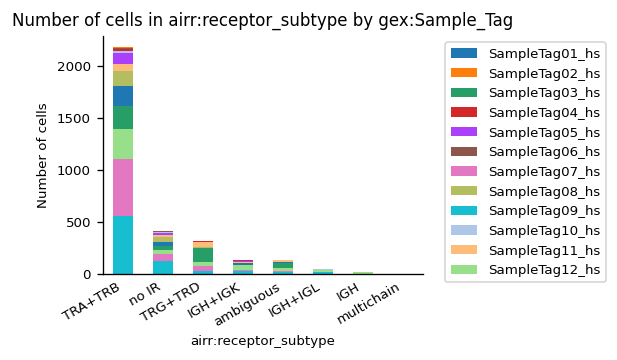

In [9]:
ax = ir.pl.group_abundance(
    mdata, groupby="airr:receptor_subtype", target_col="gex:Sample_Tag"
)

handles, labels = ax.get_legend_handles_labels()
order = np.argsort(labels);

ax.legend(
    [handles[i] for i in order], [labels[i] for i in order],
    bbox_to_anchor=(1.05, 1),
    fontsize=8
); 

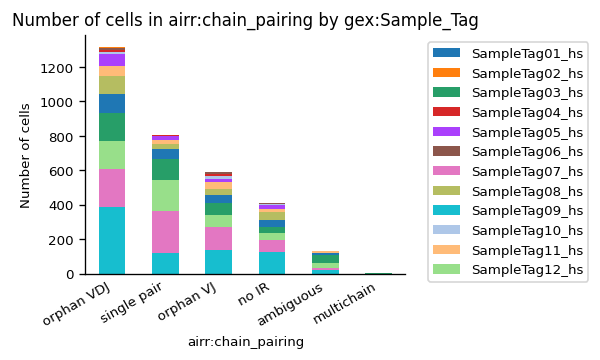

In [10]:
ax = ir.pl.group_abundance(
    mdata, groupby="airr:chain_pairing", target_col="gex:Sample_Tag"
)

handles, labels = ax.get_legend_handles_labels()
order = np.argsort(labels);

ax.legend(
    [handles[i] for i in order], [labels[i] for i in order],
    bbox_to_anchor=(1.05, 1),
    fontsize=8
); 

plt.savefig("/Users/djlisko/Desktop/chat.svg", bbox_inches="tight")

In [11]:
output = pd.DataFrame(
    {"% of Cells": (mdata["airr"].obs["chain_pairing"].value_counts() / mdata["airr"].n_obs) * 100,
"Number of Cells": mdata["airr"].obs["chain_pairing"].value_counts()}
)

output.index.name = None

output["% of Cells"] = output["% of Cells"].round(2)
output

,% of Cells,Number of Cells
orphan VDJ,40.42,1318
single pair,24.66,804
orphan VJ,18.15,592
no IR,12.63,412
ambiguous,4.11,134
multichain,0.03,1


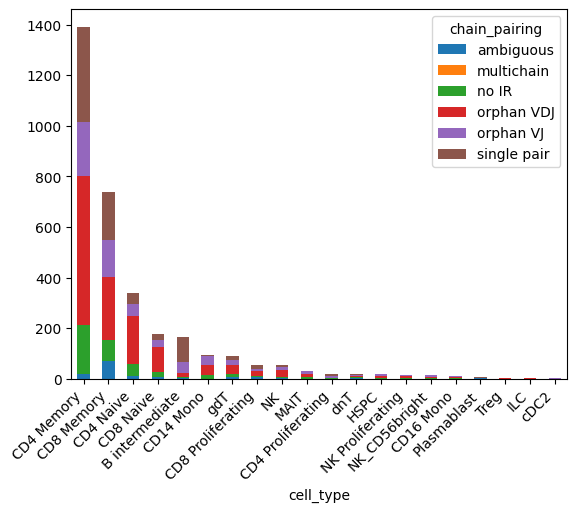

In [12]:
df = pd.DataFrame(
    {"cell_type": mdata["gex"].obs.consensus_celltype,
     "chain_pairing": mdata["airr"].obs.chain_pairing}
)
df = df.groupby("cell_type", as_index=False)["chain_pairing"].value_counts()
df = pd.pivot(
    df, 
    index="cell_type", 
    columns="chain_pairing",
    values="count")

df = df[df.sum(axis=1) > 0]
order =list(np.argsort(df.sum(axis=1)))[::-1]

df.iloc[order].plot(kind="bar", stacked=True)

plt.xticks(rotation=45, ha="right");

In [13]:
df.index.name = None
df.columns.name = None
df["total"] = df.sum(axis=1)
df.sort_values("total", inplace=True, ascending=False)
df

,ambiguous,multichain,no IR,orphan VDJ,orphan VJ,single pair,total
CD4 Memory,19,0,193,588,215,376,1391
CD8 Memory,69,0,83,252,145,191,740
CD4 Naive,10,1,48,190,48,41,338
CD8 Naive,6,0,23,98,26,26,179
B intermediate,5,0,4,16,41,99,165
CD14 Mono,1,0,16,39,34,4,94
gdT,7,0,13,36,17,19,92
CD8 Proliferating,7,0,5,19,8,17,56
NK,3,0,3,29,13,7,55
MAIT,0,0,7,13,10,3,33


## Drop Non T cells

In [14]:
airr_cells = {
    'B intermediate',
     'CD4 Memory',
     'CD4 Naive',
     'CD4 Proliferating',
     'CD8 Memory',
     'CD8 Naive',
     'CD8 Proliferating',
     'Plasmablast',
     'Treg',
     'gdT'
}

airr_bool = mdata["gex"].obs["consensus_celltype"].isin(airr_cells)
mdata = mdata[airr_bool].copy()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


# Define ClonalTypes
- We will compute a sequence-distance metric between all unique VJ CDR3 sequences and between all unique VDJ CDR3 sequences.
- This is a required proprocessing step for clonotype definition and clonotype networks and for querying reference databases.

### Define Clonal Types by Nucleotide Sequence


**scirpy.pp.ir_dist** (The distance matrices are added to adata.uns)
- computes distances between CDR3 nucleotide (nt) or amino acid (aa) sequences, either based on sequence identity or similarity.
- This function will create two distance matrices: 1) one for all unique VJ sequences and 2) one for all unique VDJ sequences.

**ir.tl.define_clonotypes** 
- matches cells based on the distances of their VJ and VDJ CDR3-sequences and value of the function parameters dual_ir and receptor_arms ()
- Finally, it detects connected modules in the graph and annotates them as clonotypes. This will add a clone_id and clone_id_size column to adata.obs.

<font color="red">**One of the following options:**</font>
- "VJ" - only consider VJ sequences
- "VDJ" - only consider VDJ sequences
- "all" - both VJ and VDJ need to match
- "any" - either VJ or VDJ need to match

**Note on any vs all:**

If "any", two distances are combined by taking their minimum. If "all", two distances are combined by taking their maximum. This is motivated by the hypothesis that a receptor recognizes the same antigen if it has a distance smaller than a certain cutoff. If we require only one of the receptors to match ("any") the smaller distance is relevant. If we require both receptors to match ("all"), the larger distance is relevant.


#### Quick Difference between Clonal Type and Clonal Clusters:

- <font color="red">Clonal Type:</font> cells with identical CDR3-sequences, each dot is also a clonotype. For each clonotype, the numeric clonotype id is shown in the graph. Basiclaly the bear the same adaptive immune receptors and recognize the same epitopes.
  
- <font color="red">Clonal Type Clusters:</font> **higher-order aggregation** of clonotypes that have **different CDR3 nucleotide sequences**, but might recognize the same antigen because they have a similar CDR3 amino acid sequence.


## With Orphan VDJ and VJ TCRs Present

### Based on Nucleotide (Aka defining cloncal Types)

In [15]:
ir.pp.ir_dist(mdata, )
ir.tl.define_clonotypes(mdata, receptor_arms="VDJ", dual_ir="primary_only")

  0%|          | 0/1588 [00:00<?, ?it/s]

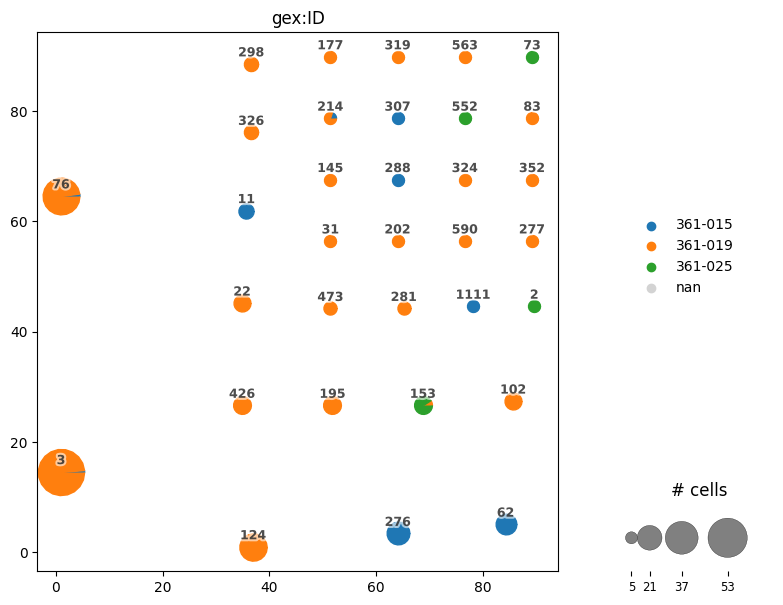

In [16]:
ir.tl.clonotype_network(mdata, min_cells=5)
_ = ir.pl.clonotype_network(
    mdata, color="gex:ID", base_size=15, label_fontsize=9, panel_size=(7, 7), 
)

### Amino-acid sequence similarity (aka Clonal Clusters)

In [17]:
# Calculate Desitance
ir.pp.ir_dist(
    mdata,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

# flexibly defines clonotype clusters 
ir.tl.define_clonotype_clusters(
    mdata, sequence="aa", metric="alignment", receptor_arms="VDJ", dual_ir="any"
)

  0%|          | 0/253 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/1589 [00:00<?, ?it/s]

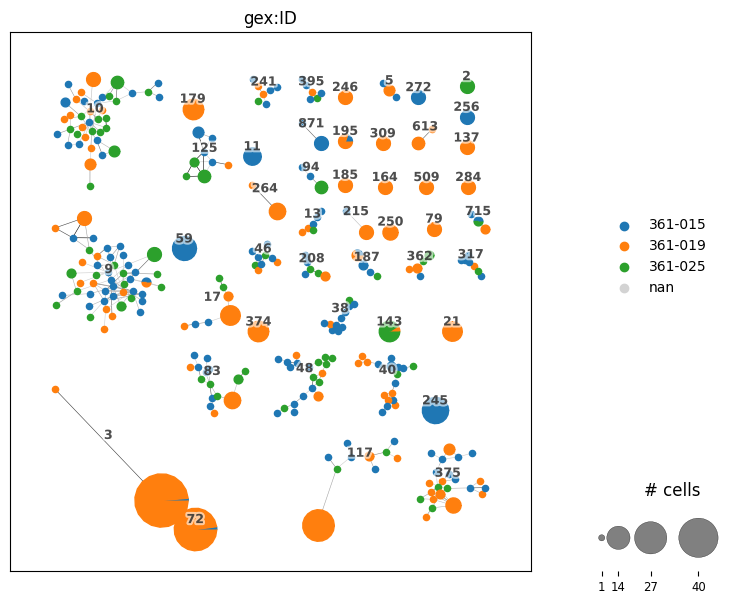

In [18]:
ir.tl.clonotype_network(mdata, min_cells=5, sequence="aa", metric="alignment")
_ = ir.pl.clonotype_network(
    mdata, color="gex:ID", label_fontsize=9, panel_size=(7, 7), base_size=20, )

## Now look at only the full chain tcrs

In [19]:
rows =mdata["airr"].obs["chain_pairing"] == "single pair"
paired_tcr = mdata[rows].copy()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [20]:
ir.pp.ir_dist(paired_tcr)
ir.tl.define_clonotypes(paired_tcr, receptor_arms="all", dual_ir="primary_only")

  0%|          | 0/629 [00:00<?, ?it/s]

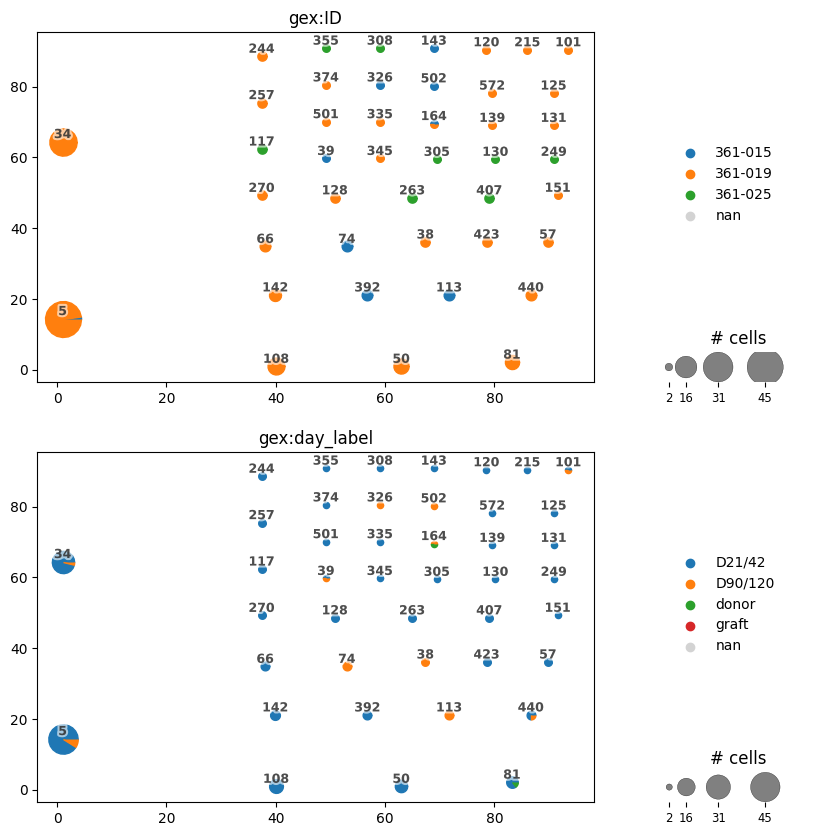

In [21]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

ir.tl.clonotype_network(paired_tcr, min_cells=2)
_ = ir.pl.clonotype_network(
    paired_tcr, color="gex:ID", base_size=15, label_fontsize=9, panel_size=(7, 7),
    ax=axes[0]
)


ir.tl.clonotype_network(paired_tcr, min_cells=2)
_ = ir.pl.clonotype_network(
    paired_tcr, color="gex:day_label", base_size=10, label_fontsize=9, panel_size=(7, 7),
    ax=axes[1]
)

In [22]:
# Calculate Desitance
ir.pp.ir_dist(
    paired_tcr,
    metric="alignment",
    sequence="aa",
    cutoff=15,
)

# flexibly defines clonotype clusters 
ir.tl.define_clonotype_clusters(
    paired_tcr, sequence="aa", metric="alignment", receptor_arms="all", dual_ir="any"
)

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/91 [00:00<?, ?it/s]

  0%|          | 0/629 [00:00<?, ?it/s]

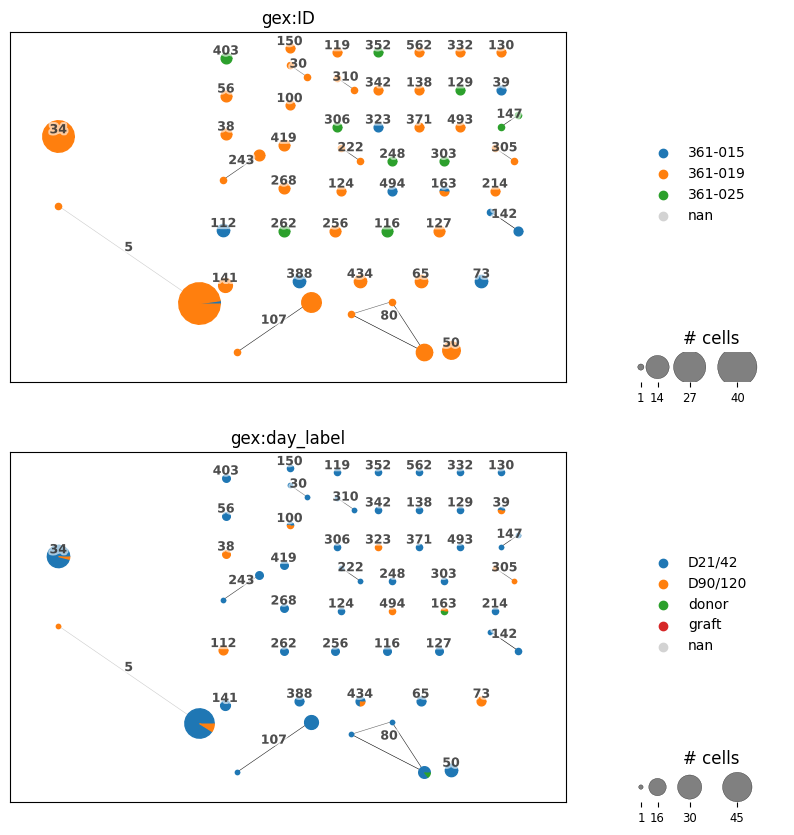

In [23]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

ir.tl.clonotype_network(paired_tcr, min_cells=2, sequence="aa", metric="alignment")
_ = ir.pl.clonotype_network(
    paired_tcr, color="gex:ID", label_fontsize=9, panel_size=(7, 7), base_size=20, ax=axes[0] )

ir.tl.clonotype_network(paired_tcr, min_cells=2, sequence="aa", metric="alignment")
_ = ir.pl.clonotype_network(
    paired_tcr, color="gex:day_label", label_fontsize=9, panel_size=(7, 7), base_size=10, ax=axes[1] )

In [24]:
def get_clonal_clusters(mdata, clone_id, clone_key="airr:cc_aa_alignment"):

    with ir.get.airr_context(mdata, "junction_aa", ["VJ_1", "VDJ_1", "VJ_2", "VDJ_2"]):
        df = (
            # TODO astype(str) is required due to a bug in pandas ignoring `dropna=False`. It seems fixed in pandas 2.x
            mdata.obs.loc[lambda x: x[clone_key] == clone_id]
            .astype(str)
            .groupby(
                [
                    "VJ_1_junction_aa",
                    "VDJ_1_junction_aa",
                    "VJ_2_junction_aa",
                    "VDJ_2_junction_aa",
                    "airr:receptor_subtype",
                ],
                observed=True,
                dropna=False,
            )
            .size()
            .reset_index(name="n_cells")
        )
    return df

In [25]:
get_clonal_clusters(paired_tcr, clone_id="81", clone_key="airr:clone_id")

,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,n_cells
0,CVVSAKAAGNKLTF,CASSIVQMNTGELFF,None,None,TRA+TRB,7


# Clonal Type Analysis

## Clonal Expansion
- based on the number of expanded clonotypes (so not the clonaltype cluster)

**Parameters to Consider**
- <font color="red">expanded_in:</font> Calculate the clonal expansion within the groups (i.e. patients/tissue)
    - If set to `None` then it will calculate late across entire dataset.
- <font color="red">breakpoints:</font> used to categorize clonotypes based on their size in a dataset. When specified as (1, 2, 5), it creates four distinct categories:
    1. Singletons: Clonotypes consisting of only one cell (size of 1).
    2. Size of 2: Clonotypes comprising exactly two cells.
    3. Size 3 to 5: Clonotypes with sizes ranging from three to five cells (inclusive).
    4. Size Greater than 5: Clonotypes with more than five cells.

In [26]:
paired_tcr["airr"].obs = paired_tcr["airr"].obs.join(paired_tcr["gex"].obs["ID"])
ir.tl.clonal_expansion(paired_tcr, expanded_in="ID", clip_at=4)

In [27]:
paired_tcr["gex"].obs["consensus_celltype"] = paired_tcr["gex"].obs["consensus_celltype"].cat.remove_unused_categories()

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


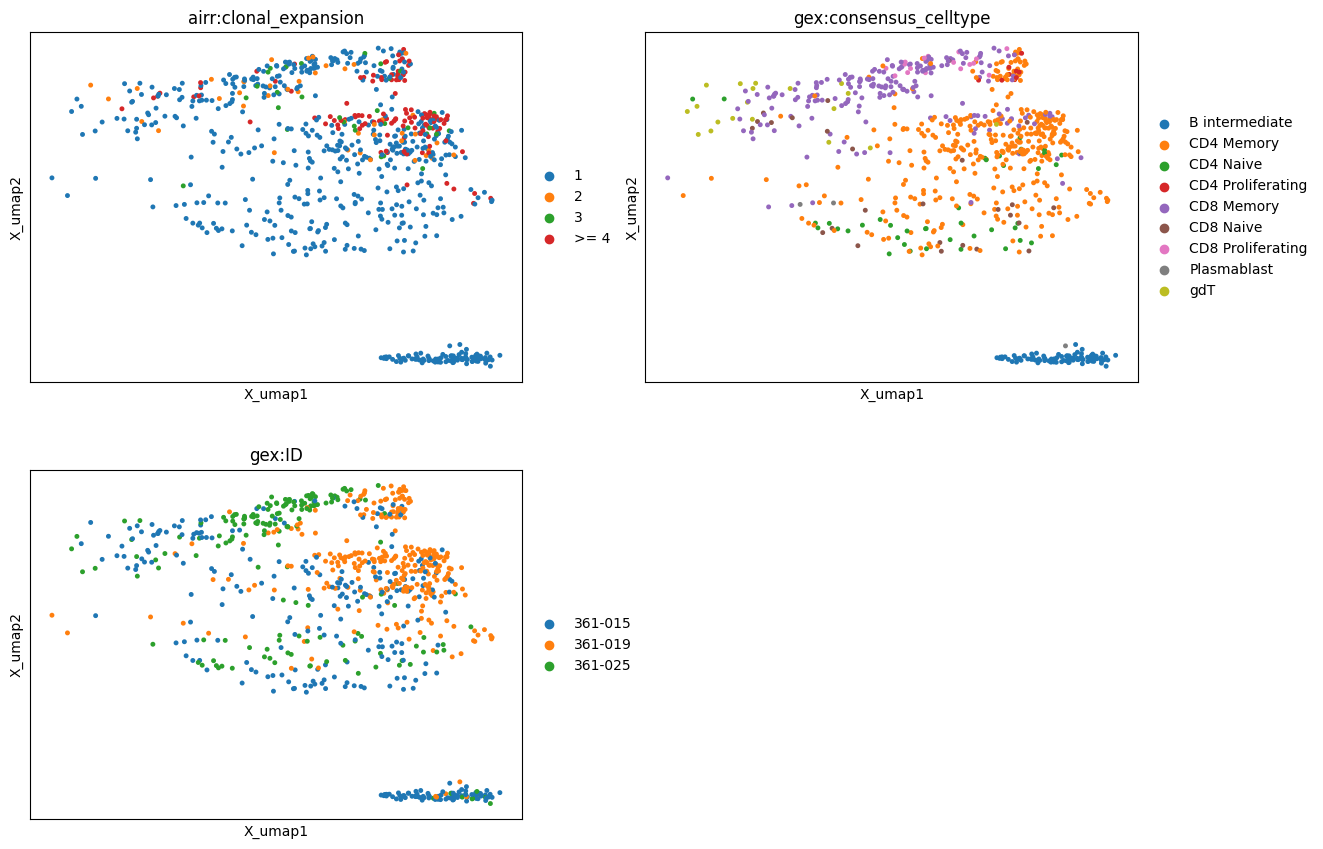

In [28]:
mu.pl.embedding(
    paired_tcr, basis="gex:umap", color=["airr:clonal_expansion", "gex:consensus_celltype", "gex:ID"], size=50, ncols=2
)

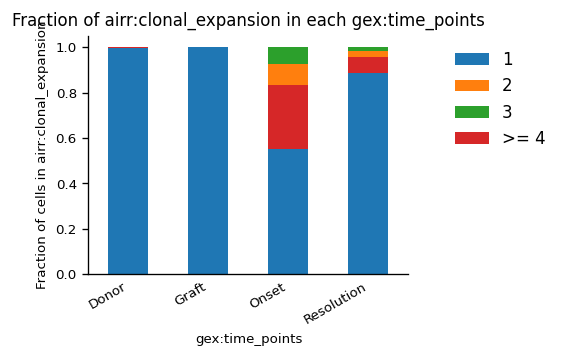

In [29]:
ax = ir.pl.group_abundance(
    paired_tcr, 
    target_col="airr:clonal_expansion", 
    groupby="gex:time_points",
    normalize=True,
    max_cols=10, 
    sort="alphabetical"
)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    [handles[i] for i in np.argsort(labels)],
    [labels[i] for i in np.argsort(labels)],
    bbox_to_anchor=(1.1, 1),
    frameon=False
)

ax.set_xticklabels(["Donor", "Graft", "Onset", "Resolution"]);

### Clonal Expansion Facted by Patient ID

In [30]:
df = paired_tcr["airr"].obs[["ID", "clonal_expansion"]].join(
    paired_tcr["gex"].obs["time_points"]
)

df = df.groupby(["ID", "time_points"], as_index=False)["clonal_expansion"].value_counts()
total_counts = df.groupby(["ID", "time_points"])["count"].transform("sum")
df["normalized"] = df["count"] / total_counts

df["normalized"].fillna(0, inplace=True)

In [31]:
df["ID"].unique()

['361-015', '361-019', '361-025']
Categories (3, object): ['361-015', '361-019', '361-025']

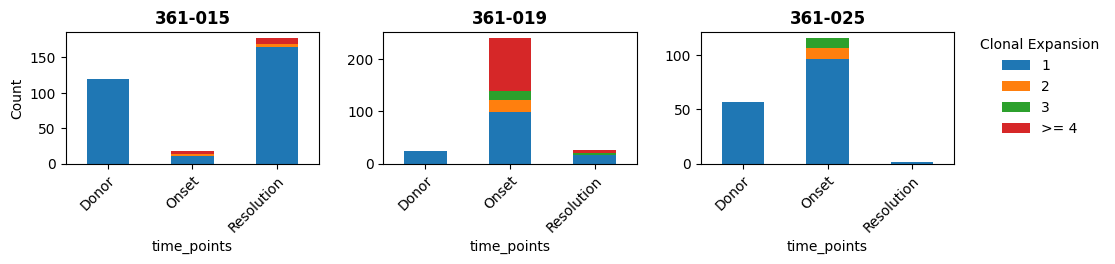

In [32]:
fig, axs = plt.subplots(ncols=3, figsize=(10, 3))
facet_by = df["ID"].unique()
# value = "normalized"
value = "count"

for pt_id, ax in zip(facet_by, axs.flatten()):
    to_plot = df[df["ID"] == pt_id].pivot_table(
        columns=["clonal_expansion"],
        index="time_points", 
        values=value,
    )

    # Dropped the graft
    if 2.0 in to_plot.index:
        to_plot.drop(2.0, inplace=True)
    
    to_plot.plot(kind="bar", stacked=True, legend=False, ax=ax)
    ax.set_title(pt_id, fontdict={"fontweight": "bold"})
    ax.set_ylabel(value.capitalize())
    ax.set_xticklabels(["Donor", "Onset", "Resolution"], 
                       rotation=45,
                       ha="right",
                       rotation_mode='anchor'
                      )



fig.legend(*ax.get_legend_handles_labels(), 
           title="Clonal Expansion", 
           loc="center right", 
           bbox_to_anchor=(1.13, 0.65),
           frameon=False
          )

# Remove Y labels from trailing plots
for ax in fig.get_axes()[1:]: 
    ax.set_ylabel(None)
    
fig.tight_layout(pad=2)

### Alpha Diversity

In [33]:
metric = "D50"

diversity = ir.tl.alpha_diversity(paired_tcr,
                                  metric=metric,
                                  groupby="Sample_Tag",
                                  inplace=False
                                 )
meta_data = paired_tcr["gex"].obs[["Sample_Tag", "ID", "time_points"]].drop_duplicates().set_index("Sample_Tag")
diversity = diversity.join(meta_data) 

# Drop the Graft from the plots
diversity = diversity[diversity["time_points"] != 2.0]

/var/folders/xz/k3tl_sxx7r7_7sftwwwf_v1m0000gq/T/ipykernel_81167/3491484897.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["Donor", "Onset", "Resolution"], rotation=45, ha="right");


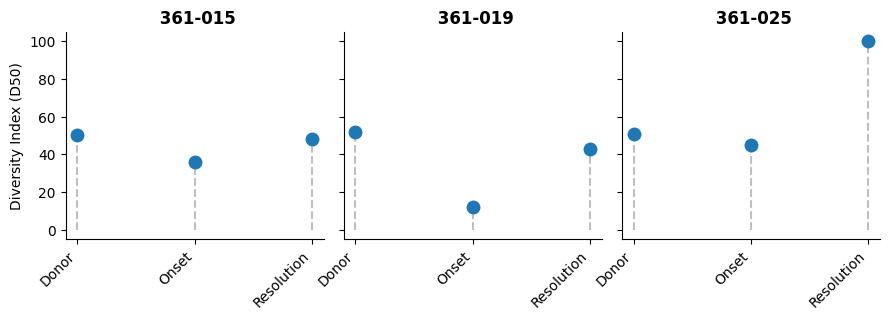

In [34]:
g = sns.FacetGrid(diversity, col="ID")
order = sorted(diversity["time_points"].unique())
g.map(sns.stripplot, "time_points", 0, order=order, size=10)

for ax in g.axes[0]:
    title = ax.get_title()
    ax.set_title(title.split("=")[-1], fontweight="bold")

for ax, (ID, subset) in zip(g.axes.flatten(), diversity.groupby("ID")):
    for x, y in zip(range(len(subset)), subset[0]):

        ax.vlines(x=x, ymin=0, ymax=y, color="gray", alpha=0.5, ls="--");

    ax.set_xticklabels(["Donor", "Onset", "Resolution"], rotation=45, ha="right");
    ax.set_xlabel("");
    ax.set_ylabel(f"Diversity Index ({metric})")

## Clonaltypes transfered

In [35]:
donor_clones = {}
recipient_clones = {}
clonal_key = "clone_id"

for pt_id, subset in paired_tcr["airr"].obs.groupby(["ID"])[[clonal_key]]:
    subset = subset.join(paired_tcr["gex"].obs["day"])
    donor_cells = (subset["day"] == "donor") | (subset["day"] == "graft")
    recipient_cells = ~donor_cells

    donor_clones[pt_id] = set(subset[donor_cells][clonal_key])
    recipient_clones[pt_id] = set(subset[recipient_cells][clonal_key])

In [36]:
recipient_clones

{'361-015': {'1',
  '102',
  '104',
  '105',
  '106',
  '110',
  '112',
  '113',
  '121',
  '133',
  '134',
  '137',
  '143',
  '15',
  '157',
  '161',
  '162',
  '164',
  '169',
  '17',
  '176',
  '179',
  '186',
  '188',
  '192',
  '195',
  '198',
  '199',
  '20',
  '201',
  '204',
  '206',
  '208',
  '210',
  '212',
  '218',
  '219',
  '224',
  '232',
  '237',
  '239',
  '24',
  '242',
  '247',
  '253',
  '254',
  '255',
  '256',
  '260',
  '268',
  '274',
  '275',
  '276',
  '279',
  '28',
  '282',
  '287',
  '288',
  '29',
  '290',
  '292',
  '299',
  '300',
  '301',
  '302',
  '319',
  '324',
  '325',
  '326',
  '33',
  '334',
  '344',
  '349',
  '350',
  '353',
  '354',
  '36',
  '360',
  '361',
  '362',
  '366',
  '367',
  '369',
  '386',
  '389',
  '39',
  '392',
  '394',
  '395',
  '400',
  '406',
  '411',
  '412',
  '413',
  '414',
  '417',
  '418',
  '42',
  '427',
  '436',
  '439',
  '441',
  '442',
  '443',
  '444',
  '446',
  '448',
  '449',
  '463',
  '464',
  '468',
  

In [37]:
transfered_clones = {}
for pt_id, clones in donor_clones.items():
    shared = recipient_clones[pt_id].intersection(clones)
    print(pt_id, shared)

361-015 set()
361-019 {'81'}
361-025 set()


# Clonal Overlap Between Samples

We can make comparisons between samples through the construction of a matrix with the abundances of clonotypes per sample (df), a Jaccard distance between samples (dst), and a linkage for hierarchical clustering (lk).


### Ways to Measure Similarity
**Jaccard Distance**
- Jaccard index is calculated by dividing the number of clonal IDs that are common to both samples (intersection) by the total number of unique clonal IDs across both samples (union).
    - <font color="red">Score of 0: </font> Share No ClonalTypes
    - <font color="red">Score of 1:</font> They share all members.

In [38]:
from matplotlib.pyplot import Text

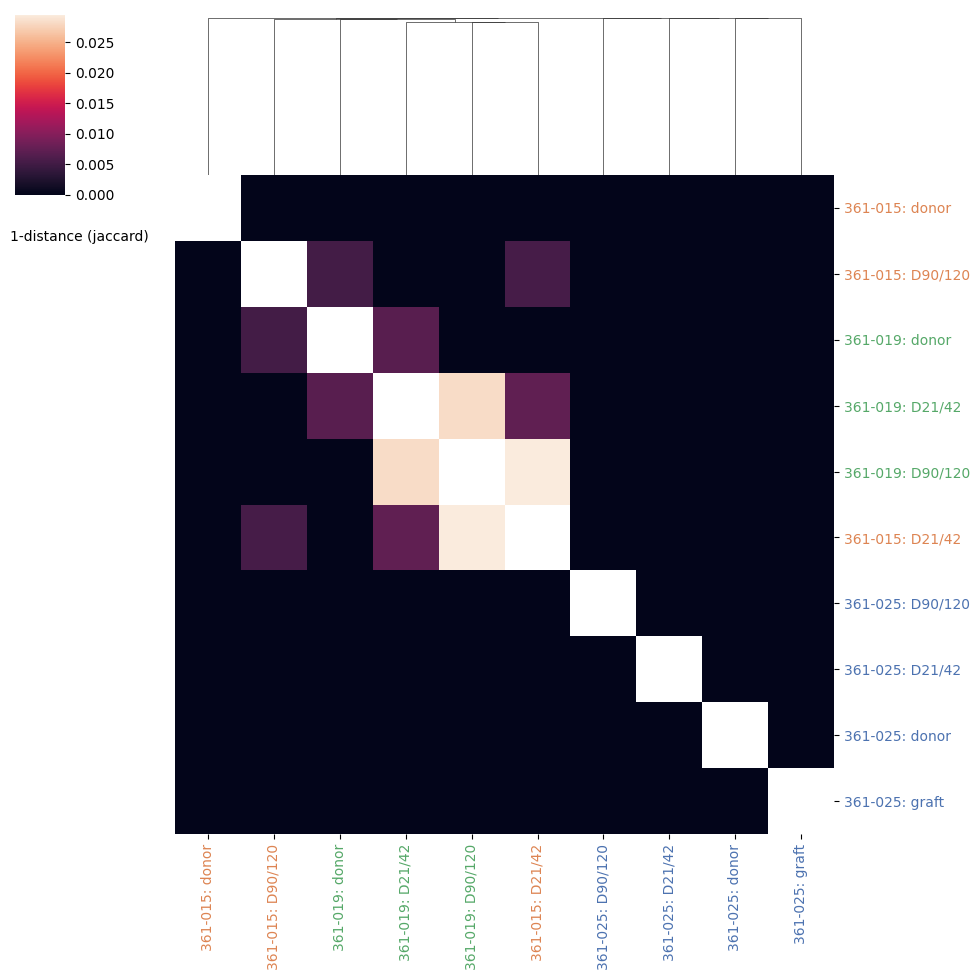

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
grid = ir.pl.repertoire_overlap(
    paired_tcr, 
    "gex:Sample_Tag",
)


# Assuming 'grid' is your ClusterGrid object from seaborn
# and 'paired_tcr' is your DataFrame

# Create a color mapping for sample IDs
unique_ids = paired_tcr["gex"].obs["ID"].unique()
palette = sns.color_palette("deep", len(unique_ids))
color_mapping = dict(zip(unique_ids, palette))

# Update the tick labels as before
ax = grid.ax_heatmap
new_axs_lbls = {row[1]: (row[2] + ": " + row[-1]) for row in paired_tcr["gex"].obs[["Sample_Tag", "ID", "day_label"]].itertuples()}

x_ticks = [new_axs_lbls[t.get_text()] for t in ax.get_xmajorticklabels()]
y_ticks = [new_axs_lbls[t.get_text()] for t in ax.get_ymajorticklabels()]

ax.set_xticklabels(x_ticks)
ax.set_yticklabels(y_ticks)

# Set the color of each tick label
for tick_label in ax.get_xticklabels():
    sample_id = tick_label.get_text().split(": ")[0]
    tick_label.set_color(color_mapping.get(sample_id, "black"))  # Default to black if ID not found

for tick_label in ax.get_yticklabels():
    sample_id = tick_label.get_text().split(": ")[0]
    tick_label.set_color(color_mapping.get(sample_id, "black"))  # Default to black if ID not found
ax.set_ylabel("")
ax.set_xlabel("")

plt.show()

 ### Compare the Paired Samples

In [40]:
new_axs_lbls

{'SampleTag03_hs': '361-025: D21/42',
 'SampleTag12_hs': '361-015: D90/120',
 'SampleTag09_hs': '361-015: donor',
 'SampleTag07_hs': '361-019: D21/42',
 'SampleTag01_hs': '361-025: donor',
 'SampleTag08_hs': '361-019: D90/120',
 'SampleTag05_hs': '361-019: donor',
 'SampleTag11_hs': '361-015: D21/42',
 'SampleTag02_hs': '361-025: graft',
 'SampleTag04_hs': '361-025: D90/120'}

In [41]:
legend_lbls = ["donor", "graft", "D21/42", "D90/120"]
palette = sns.color_palette("tab10", len(legend_lbls))
cmap = {lbl: color for lbl, color in zip(legend_lbls, palette)}
new_cols = {key: val.split()[-1] for key, val in new_axs_lbls.items()}

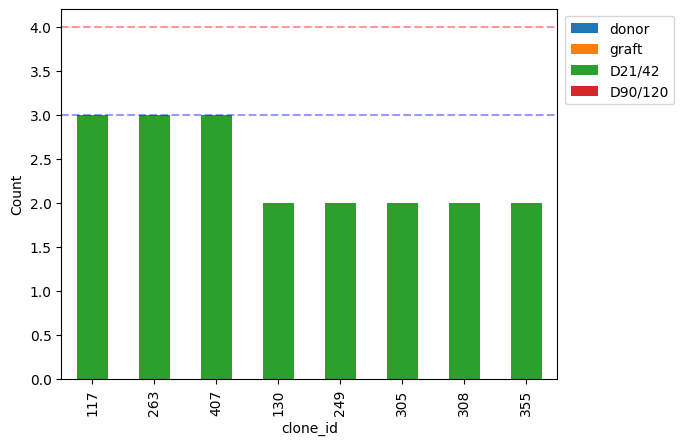

In [49]:
samples = (
    ("SampleTag05_hs", "SampleTag06_hs", "SampleTag07_hs", "SampleTag08_hs"), # 361 - 019
    ("SampleTag09_hs", "SampleTag10_hs", "SampleTag11_hs", "SampleTag12_hs"), # 361 - 015
    ("SampleTag01_hs", "SampleTag02_hs", "SampleTag03_hs", "SampleTag04_hs") # 361 -025
          )


df = paired_tcr["airr"].obs[["Sample_Tag", "clone_id", "clone_id_size", "ID"]]
df = df[df["clone_id_size"] >= 2]
df["clone_id"] = df["clone_id"].cat.remove_unused_categories()

vals =df.groupby(["Sample_Tag"], as_index=False)["clone_id"].value_counts()
vals = vals[vals["Sample_Tag"].isin(samples[2])]

vals = vals.pivot_table(index='clone_id', columns='Sample_Tag', values='count').fillna(0)
vals = vals[vals.sum(axis=1) >= 2]
vals.rename(columns=new_cols, inplace=True)

# Sort by abundnace
vals["total"] = vals.sum(axis=1)
vals.sort_values("total", inplace=True, ascending=False)
vals.drop(columns="total", inplace=True)

ax = vals.plot(kind="bar", stacked=True, color=[cmap[col] for col in vals.columns])

ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1))

ax.axhline(y=4, ls="--", c="red", alpha=0.4)
ax.axhline(y=3, ls="--", c="blue", alpha=0.4)

ax.set_ylabel("Count");

## What cells are Expanding?

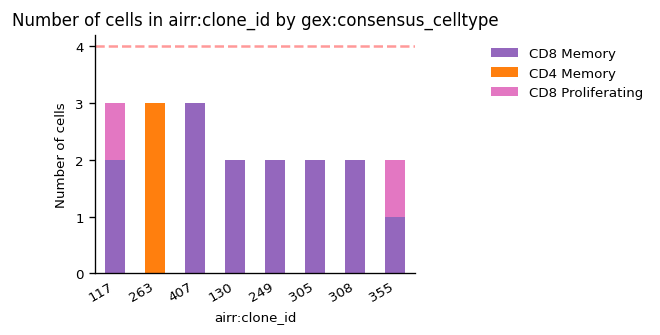

In [52]:
sample_id = "361-025"
mask = (paired_tcr.obs["gex:ID"] == sample_id) & (paired_tcr["airr"].obs["clone_id_size"] >= 2)
ax = ir.pl.group_abundance(
    paired_tcr[mask], 
    target_col="gex:consensus_celltype", 
    groupby="airr:clone_id",
    normalize=False,
    max_cols=10, 
)

ax.axhline(y=4, ls="--", c="red", alpha=0.4)

In [44]:
get_clonal_clusters(paired_tcr, clone_id="82", clone_key="airr:clone_id")

,VJ_1_junction_aa,VDJ_1_junction_aa,VJ_2_junction_aa,VDJ_2_junction_aa,airr:receptor_subtype,n_cells
0,CAVDSGTYKYIF,CASSGMGTVNNSPLHF,None,None,TRA+TRB,1


/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


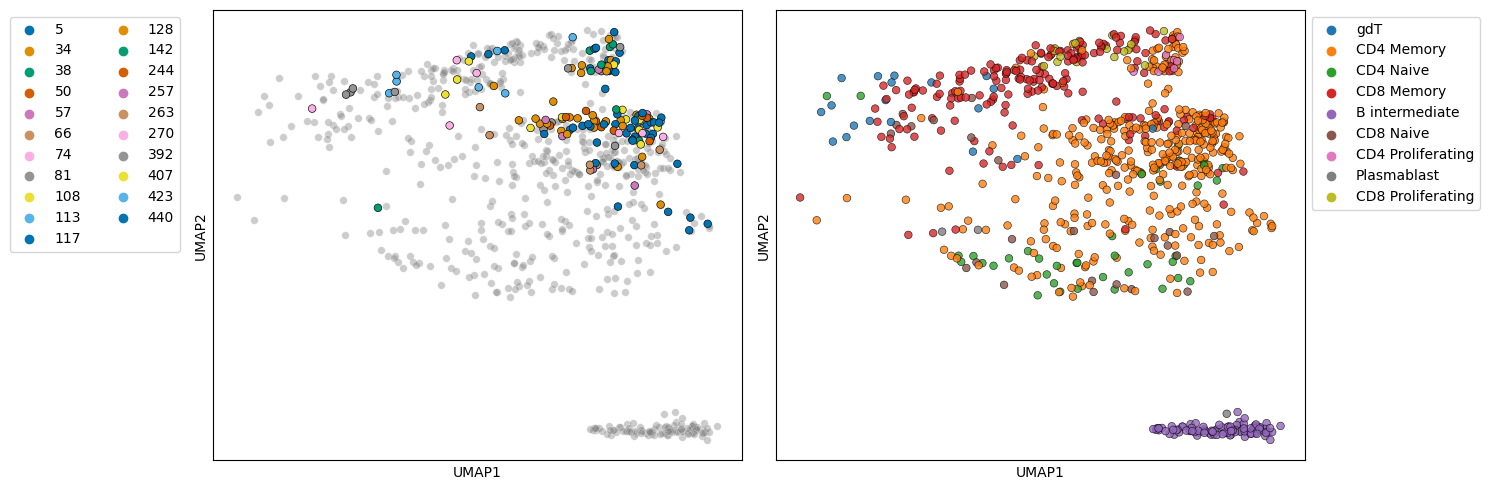

In [53]:
top_clones = []
for pt_id, subset in paired_tcr["airr"].obs.groupby("ID")[["clone_id","clone_id_size"]]:
    val_counts = subset.value_counts("clone_id")
    top_clones += list(val_counts[val_counts >= 3].index)

mask = paired_tcr.obs["airr:clone_id"].isin(top_clones)

to_plot = paired_tcr.copy()
to_plot.obs["airr:clone_id"] = to_plot.obs["airr:clone_id"].astype(str)

to_plot.obs.loc[~mask, "airr:clone_id"] = None

df = pd.DataFrame(to_plot["gex"].obsm["X_umap"], columns=["UMAP1", "UMAP2"])
df["clone_id"] = list(to_plot.obs["airr:clone_id"])

df["cell_type"] = list(to_plot.obs["gex:consensus_celltype"])


fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, color="grey", alpha=0.4, ax = axs[0])
sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, hue="clone_id", ax = axs[0], edgecolor="black", palette="colorblind")

sns.scatterplot(data=df, x="UMAP1", y="UMAP2", s=30, color="grey", alpha=0.8, hue="cell_type",ax = axs[1], edgecolor="black")

axs[0].legend(bbox_to_anchor=(-0.05, 1), ncols=2)
axs[1].legend(bbox_to_anchor=(1, 1), ncols=1)

axs[0].set_xticks([])
axs[0].set_yticks([])

axs[1].set_xticks([])
axs[1].set_yticks([])


fig.tight_layout()

In [54]:
paired_tcr["airr"].obs["is_full_chain"] = True

# Rename Clone ID Columns
original_cols = ['clone_id', 'clone_id_size', 'cc_aa_alignment', 'cc_aa_alignment_size', 'clonal_expansion']
rename = {col: "full_chain:" + col for col in original_cols}

to_save_pair = paired_tcr.copy()
to_save_pair["airr"].obs.rename(columns=rename, inplace=True)

# Update
to_update = ~to_save_pair["airr"].obs.columns.isin(mdata["airr"].obs.columns)
to_save_mdata = mdata.copy()

to_save_mdata["airr"].obs = to_save_mdata["airr"].obs.join(paired_tcr["airr"].obs.loc[:, to_update], rsuffix=":full")
to_save_mdata["airr"].obs["is_full_chain"] = to_save_mdata["airr"].obs["is_full_chain"].fillna(False)
mu.write_h5mu(mdata=to_save_mdata, filename="../data/tcr_data/121c_clone_id_full.h5mu")

/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/djlisko/gitrepos/rhapsody-analysis-notebook/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
